# Import packages

In [0]:
import pandas as pd
import numpy as np
import requests
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [0]:
# Define a function that can get n elements from dictionary
from itertools import islice
def take(n, iterable):
  return list(islice(iterable, n))

# Data preprocessing

In [0]:
# Get API data from World Trading Data, output in json format
url = "https://intraday.worldtradingdata.com/api/v1/intraday?symbol=AAPL&interval=1&range=1&api_token=<Replace with your own API token>"
response = requests.get(url)
out = response.json()

In [0]:
# Take out only close prices information
data = take(len(out['intraday']),out['intraday'].items())
data = [float(stats[1]['close']) for stats in data]
data = np.reshape(data,(1,len(out['intraday'])))
data = data.T[::-1]

In [0]:
# No need to run this block if running from beginning
data = pd.read_csv('apple_5days_data.csv')
data = data['Close'].tolist()
data = np.reshape(data,(1,len(data)))
data = data.T[::-1]

In [0]:
from sklearn import preprocessing
# Normalize data using min max scaler
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data)
from sklearn.model_selection import train_test_split
# Split data by setting 20% as test data
train, test = train_test_split(data,test_size=0.2, shuffle=False)
# Turn data into a time series
look_back = 3 # Use the past 3 days to predict the current day

def createTS(dataset, look_back=3):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back),0]
    dataX.append(a)
    dataY.append(dataset[i+look_back,0])
  return np.array(dataX), np.array(dataY)
  
# Prepare training & testing data in time series forms
X_train, y_train = createTS(train)
X_test, y_test = createTS(test)

In [0]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

# Model definition

In [0]:
model = Sequential()
model.add(LSTM(50, activation='relu',input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer="adam")

# Model training

In [0]:
model.fit(X_train, y_train, epochs=15, batch_size=1,verbose=2,validation_data=(X_test, y_test))

Train on 1555 samples, validate on 386 samples
Epoch 1/15
 - 5s - loss: 0.0184 - val_loss: 3.2117e-04
Epoch 2/15
 - 4s - loss: 6.7977e-04 - val_loss: 2.6399e-04
Epoch 3/15
 - 4s - loss: 5.6623e-04 - val_loss: 2.1922e-04
Epoch 4/15
 - 4s - loss: 5.0405e-04 - val_loss: 2.3396e-04
Epoch 5/15
 - 4s - loss: 5.2012e-04 - val_loss: 2.0220e-04
Epoch 6/15
 - 4s - loss: 4.7211e-04 - val_loss: 2.5154e-04
Epoch 7/15
 - 4s - loss: 4.8662e-04 - val_loss: 2.5409e-04
Epoch 8/15
 - 4s - loss: 4.4828e-04 - val_loss: 2.4632e-04
Epoch 9/15
 - 4s - loss: 4.5640e-04 - val_loss: 2.1098e-04
Epoch 10/15
 - 4s - loss: 4.4417e-04 - val_loss: 1.9388e-04
Epoch 11/15
 - 4s - loss: 4.6142e-04 - val_loss: 6.3997e-04
Epoch 12/15
 - 4s - loss: 4.3671e-04 - val_loss: 8.6455e-04
Epoch 13/15
 - 4s - loss: 4.2243e-04 - val_loss: 1.6841e-04
Epoch 14/15
 - 4s - loss: 4.1512e-04 - val_loss: 3.3554e-04
Epoch 15/15
 - 4s - loss: 4.3200e-04 - val_loss: 2.4853e-04


In [0]:
# Save model
model.save('model.h5')

In [0]:
# Save scaler
from sklearn.externals import joblib
joblib.dump(scaler, "scaler.save") 

['scaler.save']

# Testing using 20% of 5-day data

In [0]:
test_pred = scaler.inverse_transform(model.predict(X_test))
test_pred = [item for sublist in test_pred.tolist() for item in sublist]

In [0]:
df = pd.read_csv('apple_5days_data.csv')
true_close = df['Close'].tolist()[:len(test_pred)][::-1]

In [0]:
true_vs_pred = pd.DataFrame({'True Close':true_close,'Predicted Close':test_pred})
true_vs_pred.to_csv('true_vs_pred_rnn.csv')

# Live plotting

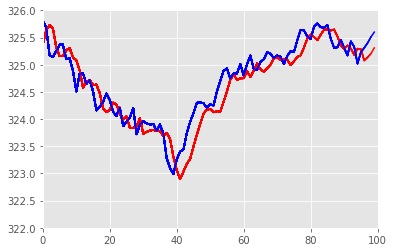

In [0]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
x = list(range(len(true_vs_pred)))
y1 = true_vs_pred['Predicted Close'].tolist()
y2 = true_vs_pred['True Close'].tolist()
for i in range(100):
    pl.plot(x[:i+1],y1[:i+1],'-r',label='Predicted Close')
    pl.plot(x[:i+1],y2[:i+1],'-b', label='True Close')
    pl.xlim(0, 100)
    pl.ylim(322, 326.5)
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)